<a href="https://colab.research.google.com/github/xxxcrttt/CASA0018----DLSN/blob/main/TinyML/Chap4_Test_and_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. What We’re Building
#### Part 1. 
目标是训练一个可以给定输入值 x 预测其正弦值 y 的模型。    
#### Part 2. 
在硬件设备上运行这个模型 -- 控制灯光进行视觉表演   
三种设备：SparkFun Edge, Arduino Nano 33 BLE Sense, ST Microelectronics STM32F736G Discovery. 



# 2. Machine Learning Toolchain

#### 1. Python and Jupyter Notebook    
#### 2. Google Colaboratory    
#### 3. TensorFlow and Keras    
**TensorFlow** -- 用于构建，训练，评估和部署ML model 的工具；  
高级API **Keras** -- 创建和训练Deep Learning Network；   
**TensorFlow Lite** -- 部署到移动端和嵌入式设备的工具

# Building Our Model

### Importing Dependencies
导入依赖项    
* ```import``` 语句用于加载库
* ```pip``` 用于下载
* 导入```TensorFlow, Numpy, Matplotlib, math ```


In [1]:
# TensorFlow is an open source ML library 
!pip install TensorFlow==2.0

     |████████████████████████████████| 86.3 MB 42 kB/s 
     |████████████████████████████████| 449 kB 48.8 MB/s 
     |████████████████████████████████| 3.8 MB 67.9 MB/s 
     |████████████████████████████████| 50 kB 6.9 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=f0d8c3f3d60c5e73bf4698e548047bf518072e983fb2fe1be4134026a908f5c7
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Success

In [2]:
import tensorflow as tf
import numpy as np # math lib
import matplotlib.pyplot as plt # graph lib
import math

### Generating Data
DL 通过学习数据内在的模式来构建模型 -- 产生模型，该模型获取一个 x 值，并预测其 sine 值 y   

计划是生成1000个代表正弦波上随机点的值；  

波的每一个完整循环被称为**周期(period)**, 正弦波的周期为 2pie   
代码将随机产生 0~2pie 的 x，并计算它们的 y 值 

**np.random.uniform()** 生成 x 值，返回指定范围内的随机数组    

**shuffle** 对数据进行随机排列 -- 重要！！以为DL中使用的训练过程依赖于以整整的随机顺序输入数据；若数据是有序的，可能不会那么准确   

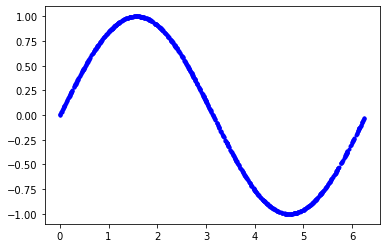

In [3]:
# Generate 1000 sample datapoint
Samples = 1000

# set a "seed" value, get the same random numbers each time, can use any value 
Seed = 1335 

np.random.seed(Seed)
tf.random.set_seed(Seed)

# Generate a uniformally distributed set of random numbers in the range(0, 2pie)
# which covers a complete sine wave oscillation 
x_values = np.random.uniform(low=0, high=2*math.pi, size= Samples)

# Shuffle the values to guarantee they are not in order 
np.random.shuffle(x_values)

# Calculate the cprresponding sine waves 
y_values = np.sin(x_values)

# plot the data
plt.plot(x_values, y_values, 'b.')
plt.show()

#### 加入噪声 noise
从噪声中过滤出模式

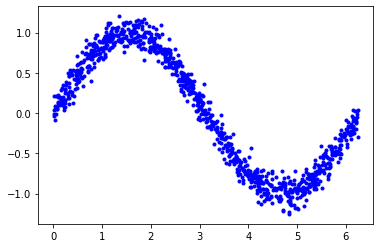

In [4]:
# Add a small random number to each y value -- noise
y_values += 0.1 * np.random.randn(*y_values.shape)

# plot
plt.plot(x_values, y_values,'b.')
plt.show()

### Splitting the Data 拆分数据
为了评估训练模型的准确率，将预测的数据与实际的数据进行比较，检查匹配程度   

60% -- training + 20% -- validation + 20% -- testing  

**np.split()** 输入一个数据数组 + 一个索引数组，根据提供的索引将数据分为若干部分

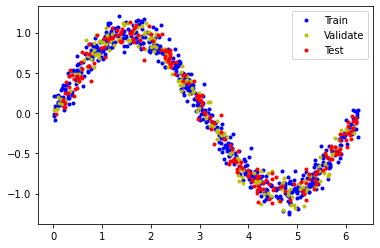

In [5]:
# 60% -- training + 20% -- validation + 20% -- testing   
train_split = int(0.6*Samples)
test_split = int(0.2*Samples + train_split)

# split the data into 3 parts. 
x_train, x_vali, x_test = np.split(x_values, [train_split, test_split])
y_train, y_vali, y_test = np.split(y_values, [train_split, test_split])

# double check that the splits add up correctly 
assert (x_train.size + x_vali.size + x_test.size) == Samples

# plot 
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_vali, y_vali, 'y.', label="Validate")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.legend()
plt.show()

### Defining a Basic Model 定义基本模型
**回归(regression)**:    
接受一个输入值并预测一个数字输出值 -- 训练任何需要输出数字的任务 

**keras.Sequential()**:    
序列模型 -- 表示模型中的每一层神经都堆叠在下一层之上   

**第一层**：
```
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))
```
只有一个输入(x) & 16 neurons, 这是一个**Dense(密集) / 全连接层(fully connected layer)**层   

在推断过程中的输入将被输入这一层的*每一个*神经元中  

然后每个神经元将在一定程度上被**激活(activate)**, 每个神经元的激活量取决于它在训练过程中获得的**权重(weight) & 偏差(bias)**, 以及它的**激活函数(activation function)** -- 用于模拟神经元 

神经元的激活方式将以数字的形式输出，激活程度通过简单公式计算，由TensorFlow处理 -- 输入 X 权重 + 偏差 
```
activation = activation_function((input * weight) + bias)
```
线性整流单元 -- Rectified Linear Unit, ReLU 
```
activation = 'relu'
```
ReLu 返回 input & 0 中较大的值 -- 若 input 为负，返回 0；否则返回 input 
```
ReLU 函数:
def relu(input):
    return max(0.0, input)
```

若没有激活函数，神经元的输出将始终是其输入的线性函数，意味着网络只能对线性关系建模，x 和 y 的比值在一定范围内相同  

非线性关系允许多层神经元相互作用

来自第一层的激活函数将作为第二层的输入, 由单个神经元组成，接受16个输入(上层每个神经元的输出)    
-- 目的是奖上一层的所有激活函数程度值合并为一个输出值 
```
model_1.add(layers.Dense(1))
```
输出通过以下公式计算:
```
output = sum((inputs * weights) + bias)
```

网络的权重和偏差是训练期间学习得到的，compile() 步骤配置了训练过程中使用的重要参数和训练模型:
```
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
```
**optimizer()优化器** 指定在训练期间用于调整网络以对其输入进行建模的算法 -- 有很多选择    
**loss()损失函数** 指定了训练期间用来计算网络预测值与真实值之间的距离的方法 -- loss function   
* mse  = mean squared error (均方误差)    

**metrics(度量指标)** 指定用于评测模型表现的函数   
* mae  = mean absolute error (平均绝对误差)

**summary()** 显示了网络层，输出形状和参数数目

网络大小 -- 占用内存 -- 主要取决于参数 == 权重 + 偏差 

对于简单模型，可以通过计算模型中神经元之间的连接数目来得到权重的数目 






In [6]:
from tensorflow.keras import layers
# 这里不能写 tf.keras -- cannot use the alias to import other modules
# 序列模型：
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 neurons 
# neurons decide whether to activate based on the 'relu' activation function.
# 第一层定义：
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# Final layer is a single neuron -- output is a single value 
# add 16 neurons together 
# 第二层: 
model_1.add(layers.Dense(1))

# Compile the model using a standard optimiser and loss function for regression
# 配置重要参数和训练模型 
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

# print a summary of the model's architecture
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


# Training Model 训练模型

**fit()** -- 训练模型，传入所有数据和重要参数

调用的返回值赋给了名为 history_1 的变量，它包含大量有关于训练运行情况的信息 

参数：

x_train & y_train: 

训练数据 x 和 y 值，将会保留部分数据用于验证和测试，因此只使用训练集来训练网络

epochs(次数): 

指定在整个训练期间通过网络运行的轮次总数；epoches越大训练次数越多 -- 并不是越多越好，过拟合问题

batch_size: 

指定在测量网络的准确率并更新其权重和偏差之前，需要向网络输入多少训练数据 --    
设定为 1 时意味着将在单个数据点上运行   
研究表明: 使用大批次进行训练的模型推广到新数据的能力较低，它们更容易出现过拟合的问题 -- 折中方案是使用居中的批次大小

validation_data: 

指定验证数据集


In [7]:
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16, 
                        validation_data = (x_vali, y_vali))

Train on 600 samples, validate on 200 samples
Epoch 1/1000
600/600 [==============================] - 1s 1ms/sample - loss: 0.6837 - mae: 0.7207 - val_loss: 0.5170 - val_mae: 0.6395
Epoch 2/1000
600/600 [==============================] - 0s 151us/sample - loss: 0.4254 - mae: 0.5674 - val_loss: 0.4418 - val_mae: 0.5722
Epoch 3/1000
600/600 [==============================] - 0s 144us/sample - loss: 0.3722 - mae: 0.5244 - val_loss: 0.3912 - val_mae: 0.5381
Epoch 4/1000
600/600 [==============================] - 0s 130us/sample - loss: 0.3285 - mae: 0.4940 - val_loss: 0.3413 - val_mae: 0.5078
Epoch 5/1000
600/600 [==============================] - 0s 171us/sample - loss: 0.2918 - mae: 0.4675 - val_loss: 0.3052 - val_mae: 0.4785
Epoch 6/1000
600/600 [==============================] - 0s 150us/sample - loss: 0.2594 - mae: 0.4394 - val_loss: 0.2698 - val_mae: 0.4566
Epoch 7/1000
600/600 [==============================] - 0s 167us/sample - loss: 0.2324 - mae: 0.4191 - val_loss: 0.2356 - val_ma

### Training Metrics 训练度量指标

显示网络在训练过程中是如何从随机初始状态开始一步步改进的
```
epoch 1/1000
600/600 [==============================] - 1s 2ms/sample - loss: 0.3970 - mae: 0.5458 - val_loss: 0.4112 - val_mae: 0.5568

epoch 1000/1000
600/600 [==============================] - 0s 202us/sample - loss: 0.1310 - mae: 0.2777 - val_loss: 0.1157 - val_mae: 0.2657
```
**loss**

损失函数的输出，使用均方误差，值都是正数 -- 一般来说损失值越小越好

**mae** 

训练数据的平均绝对误差，显示了网络预测值和训练数据中 y 值之间的平均差 

**val_loss** 

损失函数在验证数据上的输出，最后一轮中训练损失值(约0.15)略低于验证损失值(约0.17)，表明网络可能出现了过拟合，因为他在处理从未见过的数据时表现力较差

**val_mae** 

验证数据的平均绝对误差 


### Graphing the History 绘制历史数据
history_1 对象包含了名为 history_1.history 的属性，是一个字典，用于记录训练期间和验证期间的度量指标

如图，在前50个轮次，损失迅速减少，然后趋近于平缓 ==》 该模型正在改进并产生更准确的预测

目标： 当模型不再改进 or 训练损失小于实验损失时停止训练 ==》 意味着模型已经学会了很好的预测训练模型

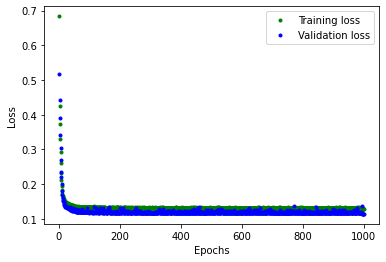

In [8]:
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b.', label="Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### 放大 

损失在前几个轮次急速下降，使得图片很难读懂，此时跳过前 100 个轮次

放大了后面的轮次可以看到损失仍在持续减少，until about 600 epochs. 而且验证损失值始终比训练损失高

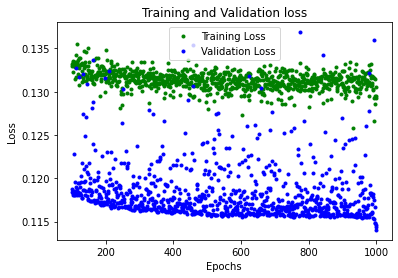

In [9]:
# Exclude the first 100 epochs 
Skip = 100

plt.plot(epochs[Skip:], loss[Skip:],'g.', label='Training Loss')
plt.plot(epochs[Skip:], val_loss[Skip:],'b.', label='Validation Loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### MAE 平均绝对误差

平均而言，训练数据的误差低于验证数据的误差 ==》 网络可能存在过拟合

且MAE误差非常高(0.31)，意味着模型的某些预测误差至少为 0.31



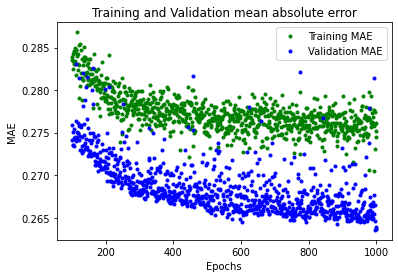

In [10]:
# plot mean absolute error
# another way of measuring the amount of error in the prediction 
mae = history_1.history['mae']
val_mae = history_1.history['val_mae']

plt.plot(epochs[Skip:], mae[Skip:], 'g.', label='Training MAE')
plt.plot(epochs[Skip:], val_mae[Skip:], 'b.', label='Validation MAE')
plt.title('Training and Validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

#### 网络期望值
网络对于训练数据的预测值和期望值 

通过调用```model_1.predict(x_train)```可以对训练数据中所有的 x 值进行推断，返回一个预测数组

清楚表明：网络已经学会以非常有限的方式接近正弦函数，这些预测是高度线性的，并且只能非常粗略的拟合数据

这种僵化的拟合表明：模型*没有* 足够的能力来学习 sine 的函数的全部复杂性，因此只能以非常简单的方式进行近似

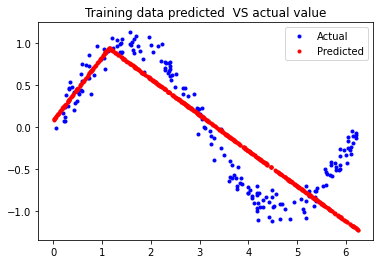

In [11]:
# use the model to make predictions from validation data
predictions = model_1.predict(x_train)

# plot the predictions along with the test data 
plt.clf()
plt.title('Training data predicted  VS actual value')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_train, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

### Improving Model  改进模型

使得网络更大的一个简单方法是添加另一层神经元，神经元的每一层都代表对输入的一次转换，并希望可以使得转换后的结果更接近预期的输出

网络具有的神经元层数越多，转换就越复杂

新模型有两层包含 16 个神经元的额层，具有 ```288 weights + (16 + 16 + 1) = 33 bias = 321 para```


In [12]:
# Add 2nd layer model
model_2 = tf.keras.Sequential()

model_2.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# The new 2nd layer may help the network learn more complex representations
model_2.add(layers.Dense(16, activation='relu'))

# Final layer is a single neuron, 
model_2.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression 
model_2.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])

# show a summary of the model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


改进： 

验证损失： 0.17 --> 0.01

验证平均误差: 0.32 --> 0.08

```
Epoch 1/600
600/600 [==============================] - 1s 1ms/sample - loss: 2.2686 - mae: 1.2070 - val_loss: 1.1358 - val_mae: 0.9161
Epoch 600/600
600/600 [==============================] - 0s 194us/sample - loss: 0.0113 - mae: 0.0841 - val_loss: 0.0104 - val_mae: 0.0830
```

In [13]:
history_2 = model_2.fit(x_train, y_train, epochs=600, batch_size=16,
                         validation_data=(x_vali, y_vali))

Train on 600 samples, validate on 200 samples
Epoch 1/600
600/600 [==============================] - 1s 1ms/sample - loss: 0.6555 - mae: 0.7045 - val_loss: 0.4938 - val_mae: 0.6191
Epoch 2/600
600/600 [==============================] - 0s 153us/sample - loss: 0.3968 - mae: 0.5464 - val_loss: 0.3985 - val_mae: 0.5439
Epoch 3/600
600/600 [==============================] - 0s 169us/sample - loss: 0.3257 - mae: 0.4906 - val_loss: 0.3256 - val_mae: 0.4933
Epoch 4/600
600/600 [==============================] - 0s 169us/sample - loss: 0.2590 - mae: 0.4404 - val_loss: 0.2422 - val_mae: 0.4310
Epoch 5/600
600/600 [==============================] - 0s 173us/sample - loss: 0.2035 - mae: 0.3927 - val_loss: 0.1927 - val_mae: 0.3840
Epoch 6/600
600/600 [==============================] - 0s 174us/sample - loss: 0.1693 - mae: 0.3580 - val_loss: 0.1612 - val_mae: 0.3511
Epoch 7/600
600/600 [==============================] - 0s 182us/sample - loss: 0.1484 - mae: 0.3329 - val_loss: 0.1388 - val_mae: 0.32

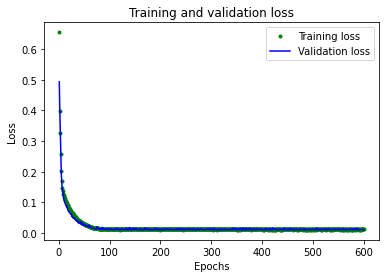

In [14]:
# Draw a graph of the loss = the distance between 
# the predicted and actual values during training and validation 
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

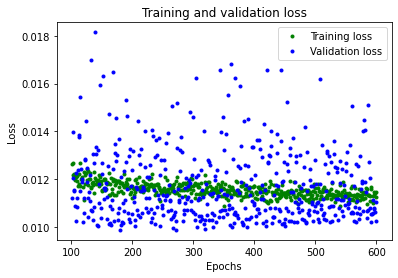

In [15]:
# Exclude the first 100 epochs 
Skip = 100

plt.clf()

plt.plot(epochs[Skip:], loss[Skip:], 'g.', label='Training loss')
plt.plot(epochs[Skip:], val_loss[Skip:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

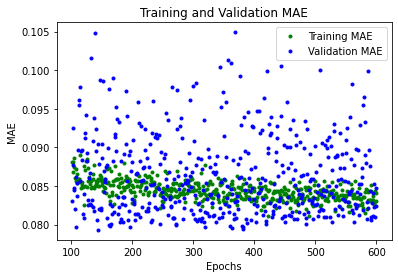

In [16]:
# mean absolute value 
mae = history_2.history['mae']
val_mae = history_2.history['val_mae']

plt.plot(epochs[Skip:], mae[Skip:], 'g.',label='Training MAE')
plt.plot(epochs[Skip:], val_mae[Skip:],'b.',label='Validation MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

很好的结果！！
* 总体来说，验证集上的度量数据要好于训练集 ==》 网络没有出现过拟合
* 整体损失和平均绝对误差比之前的网络要好

验证集的度量数据是每个轮次结束时计算的，而训练数据的度量数据是在训练期间计算的 

==》 意味着验证是在训练了较长时间的模型上进行的

### Testing 


200/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

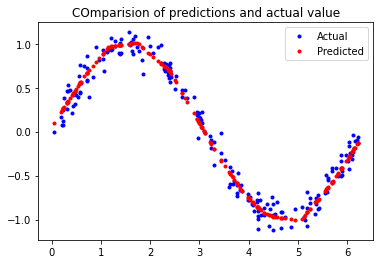

In [17]:
# calculate and print the loss on test dataset
loss = model_2.evaluate(x_test, y_test)

# Make predictions based on test dataset
predictions = model_2.predict(x_test)

# Graph the predictions against the actual value
plt.clf()
plt.title('COmparision of predictions and actual value')
plt.plot(x_test, y_test, 'b.', label='Actual')
plt.plot(x_test, predictions, 'r.', label='Predicted')
plt.legend()
plt.show()

**evaluate()** 

测试数据调用模型，会计算并打印损失值和平均绝对误差，模型的预测值和实际值的偏离程度
 ```
 - 0s 58us/sample - loss: 0.0102 - mae: 0.0856
 ```
输出表明：评估了200个数据点 -- 及整个测试集，花费了 71 ms，损失值为 0.0102，接近验证损失 0.0104；平均绝对误差 0.0856，接近验证集中的0.0806 



以上是模型学习到的随机分布的变化，是一个**轻微过拟合**的状态：模型学习的并不是平滑的 sine 函数，而是复制了数据的精确情况 



## TensorFlow Lite 转换模型

用于 “边缘设备” (edge device) -- 手机 / 微控制器

* 转换器 (convert), tf model -> FlatBuffer；对模型进行优化 （虽然以降低准确率为代价，但是降低幅度很小，优化是值得的） 
* 解释器 (interpreter), 以有效方式在特定设备上运行
* 最有用的优化之一 -- 量化 (quantization)， 模型中的权重和偏差被存储为 32 bit float，以便进行高精度运算；  
量化降低精度，使它们可以存储为 8 bit int -- 通常精度损失都很小，量化几乎都是值得的


In [18]:
# convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)

tflite_model = converter.convert()

# save the file to disk
open("sine_model.tflite","wb").write(tflite_model)

2736

* 为创建一个尽可能高效的量化模型，提要提供一个*代表线性数据集* (representative dataset), 这组数据表示模型训练数据集所有输入值的范围
* 定义一个函数```representative_dataset_generator()``` 使用 **yield** 运算符逐个返回

In [22]:
# convert the model with quantization 
converter = tf.lite.TFLiteConverter.from_keras_model(model_2)

# indicate that we want to perform the default optimization 
# this includes quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# define a generator function that provides the test data 
# as a representative dataset, 
def representative_dataset_generator():
  for value in x_test:
    # Each scalar value must be inside of a 2D array what is wrapped into a list 
    yield [np.array(value, dtype=np.float32, ndmin=2)]
  
converter.representative_dataset = representative_dataset_generator

# convert the model
tflite_model = converter.convert()

# Save 
open("sine_model_quantized.tflite","wb").write(tflite_model)

2512

* 使用转换后的模型进行预测并将结果与原来测试结果比较以证明量化的准确性 -- 使用解释器

* **解释器** 主要是以提高效率为目的，以下步骤：
1. 实例化一个 Interpreter 对象 
2. 调用一些为模型分配内存的方法
3. 将输入写入输入张量（input tensor）
4. 调用模型
5. 读取张量的输出

In [23]:
# Instantiate an interpreter for each model 
sine_model = tf.lite.Interpreter("sine_model.tflite")
sine_model_quantized = tf.lite.Interpreter("sine_model_quantized.tflite")

# Allocate memory for each model 
sine_model.allocate_tensors()
sine_model_quantized.allocate_tensors()

In [24]:
# Get index of the input and output sensors
sine_model_input_index = sine_model.get_input_details()[0]["index"]
sine_model_output_index = sine_model.get_output_details()[0]["index"]
sine_model_quantized_input_index = sine_model_quantized.get_input_details()[0]["index"]
sine_model_quantized_output_index = sine_model_quantized.get_output_details()[0]["index"]

# Create arrays to store the results
sine_model_predictions = []
sine_model_quantized_predictions = []

In [26]:
# Run each model's intepreter for each value and store the results in arrays 
for x_value in x_test: 

  # Create a 2D sensor wrapping the current x value 
  x_value_tensor = tf.convert_to_tensor([[x_value]], dtype=np.float32)

  # Write the value to the input sensor 
  sine_model.set_tensor(sine_model_input_index, x_value_tensor)

  # Run inference 
  sine_model.invoke()

  # Read the prediction from the output tensor 
  sine_model_predictions.append(sine_model.get_tensor(sine_model_output_index)[0])

  # for quantized model 
  sine_model_quantized.set_tensor(sine_model_quantized_input_index, x_value_tensor)
  sine_model_quantized.invoke()
  sine_model_quantized_predictions.append(sine_model_quantized.get_tensor(sine_model_quantized_output_index)[0])


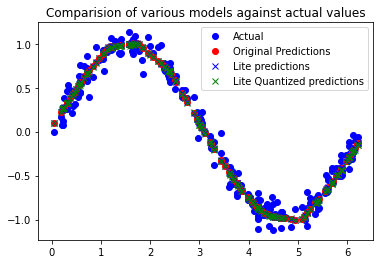

In [28]:
# See how they line up with the data 
# 比较模型预测值与实际值的图
plt.clf()
plt.title("Comparision of various models against actual values")
plt.plot(x_test, y_test, 'bo', label='Actual')
plt.plot(x_test, predictions, 'ro', label='Original Predictions')
plt.plot(x_test, sine_model_predictions, 'bx', label='Lite predictions')
plt.plot(x_test, sine_model_quantized_predictions, 'gx', label='Lite Quantized predictions')
plt.legend()
plt.show() 

* 原始模型，转换模型，量化模型，预测值都非常接近！
* 比较两个转换后的模型大小： 
```
basic model is 2736 bytes
quantized model is 2512 bytes
difference is 224 bytes
```
模型大小约为2.4 KB，权重和偏差仅仅占很小一部分。此外模型还白喊构成DL network architecture 的所有逻辑，**计算图**(computation graph) 



In [30]:
# compare the size
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("difference is %d bytes" % difference)

basic model is 2736 bytes
quantized model is 2512 bytes
difference is 224 bytes


## 转换为 C.file
* 最后一步是将模型转换为可以包含在应用程序中的 C语言源文件
* 在文件中定义模型为字节数组，在量化模型上运行 xxd(UNIX 工具)，将输入写入名为```sine_model_quantized.cc```的文件中，并打印到屏幕上 

In [31]:
# install xxd i fit is not availabel 
!apt-get -qq install xxd

Selecting previously unselected package xxd.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.7_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.7) ...
Setting up xxd (2:8.0.1453-1ubuntu1.7) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [33]:
# save the file as a C source file 
!xxd -i sine_model_quantized.tflite > sine_model_quantized.cc

In [34]:
# print the source file
!cat sine_model_quantized.cc

unsigned char sine_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0x60, 0x09, 0x00, 0x00, 0xa8, 0x02, 0x00, 0x00, 0x90, 0x02, 0x00, 0x00,
  0x3c, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x04, 0x00, 0x08, 0x00,
  0x08, 0x00, 0x00, 0x00, 0x08, 0x00, 0x00, 0x00, 0x0b, 0x00, 0x00, 0x00,
  0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f, 0x72, 0x75, 0x6e, 0x74,
  0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73, 0x69, 0x6f, 0x6e, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x48, 0x02, 0x00, 0x00, 0x34, 0x02, 0x00, 0x00,
  0x0c, 0x02, 0x00, 0x00, 0xfc, 0x00, 0x00, 0x00, 0xac, 0x00, 0x00, 0x00,
  0x8c, 0x00, 0x00, 0x00, 0x3c, 0x00, 0x00, 0x00, 0x34, 0x00, 0x00, 0x00,
  0x2c, 0x00, 0x00, 0x00, 0x24, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x